# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.11.0


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [4]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_mdn_08_04_lesser_ratio'


os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu/results/toy_example_mdn_08_04_lesser_ratio


In [5]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [6]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [7]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [8]:
samples_prior_list = samples_prior.unsqueeze(0)

In [9]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [10]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


In [11]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [12]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.335
acceptance rate:  0.32527272727272727


/home/ubuntu/pyknos/pyknos/mdn/mdn.py:288: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755861072/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  chosen_precision_factors,


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.328
acceptance rate:  0.33254545454545453
tensor([4.8797, 5.5033, 6.0454, 3.8470, 3.8339, 9.0478, 8.3753, 5.4434, 3.9260,
        8.7650, 2.0372, 4.3247, 2.8190, 8.0129, 4.4551])
tensor([11.3357, 24.5294, 29.0603,  8.8281, 72.1627, 51.9298, 36.4898, 43.3906,
         7.7360, 74.8680,  3.7379, 48.5236, 96.5125, 26.9169, 36.5921])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 44.5629, 184.6082,  57.0185,   6.2391, 164.5905,  42.9422,  77.4749,
         146.9469,  12.8179,  47.5906,   1.6600, 160.0987,   5.5308, 115.1057,
          43.2764]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.256
acceptance rate:  0.261


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.274
acceptance rate:  0.2670909090909091
tensor([ 5.4051,  4.8742,  6.6137, 11.9852,  5.7963,  6.6314,  4.0725,  5.7167,
         4.8220,  7.2565,  6.2206,  6.1612,  3.7161,  4.6494,  6.4312])
tensor([12.2368, 11.4823, 46.4129, 31.6577, 91.4439, 58.5651, 10.5917, 36.1125,
        15.3480, 61.0627, 19.8203, 78.2692, 95.4516, 41.8342, 47.7435])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 55.0801,  24.8224, 368.3019, 303.3653,  15.5836,  25.9507, 141.0041,
          55.6157,  73.9405,  63.7846, 126.8415,  91.9279,  11.3876,  10.4539,
          22.0825]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.93
acceptance rate:  0.9338181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.937
acceptance rate:  0.9288181818181818
tensor([8.6704, 5.8392, 4.0670, 4.5946, 7.4395, 3.3239, 9.0581, 4.4678, 9.9776,
        6.5265, 3.8027, 2.9148, 3.1028, 6.5005, 8.1213])
tensor([30.2233, 28.5422, 36.1787, 24.3660, 60.6019, 59.0577, 50.1530, 33.3310,
        43.2307, 54.8495, 20.9640, 50.8235, 91.0169, 22.7826, 80.4722])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[405.4819, 268.8586, 137.2422, 111.7211, 457.2900,  12.0555, 306.3508,
          28.0248, 816.4997, 133.6903, 132.8192, 117.8406,  35.0464, 166.9751,
         659.5210]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.239
acceptance rate:  0.26127272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.246
acceptance rate:  0.25845454545454544
tensor([1.7230, 1.6706, 4.4463, 1.3240, 3.0787, 2.3877, 1.5625, 2.3252, 2.2352,
        0.8728, 1.5826, 1.5041, 3.1932, 2.8773, 4.1752])
tensor([ 4.8622,  3.4768, 22.1431,  8.9646, 92.4778, 53.5364, 27.1084, 27.1493,
         4.9515, 68.5947,  3.4568, 64.8279, 94.9580, 40.6227, 42.0139])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.1742,  3.5654, 10.1892,  0.6319,  6.1846,  2.5513,  0.2803,  1.3707,
          1.6464,  1.0044,  1.4839,  0.9099, 11.6064,  2.7765, 11.2453]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.874
acceptance rate:  0.8726363636363637


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.869
acceptance rate:  0.8740909090909091
tensor([5.1530, 7.5373, 7.4217, 5.8336, 5.1177, 1.6821, 1.6118, 3.1554, 3.9218,
        3.4177, 2.7332, 2.8430, 4.6964, 4.7171, 6.9824])
tensor([16.6415, 34.0476, 18.0495, 21.5503, 88.7927, 51.5745, 28.1192, 17.6780,
         8.8827, 65.3452, 15.9761, 71.8860, 89.6079, 38.7751, 36.2381])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[104.1828, 419.2189,  26.9384,  81.4561,  11.6913,   6.2616,   0.9480,
          46.7794,  17.7443,  14.9448,  62.4670,  19.8188,  53.0869,   9.8245,
          60.3191]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.289
acceptance rate:  0.2849090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.29
acceptance rate:  0.2891818181818182
tensor([2.5185, 4.3029, 7.6385, 2.0703, 3.0258, 1.7317, 2.1493, 3.6026, 1.4177,
        2.3505, 1.3467, 3.1812, 3.0482, 2.1692, 8.6604])
tensor([ 8.7173, 13.5345, 34.9846, 14.1985, 88.1068, 52.4702, 29.7314, 33.3676,
         2.8754, 64.5550,  6.9604, 58.7059, 93.9390, 35.3531, 28.6584])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 18.0915,  35.6827, 138.9088,   9.7289,   4.7626,   3.6503,   4.7750,
          24.9810,   0.7882,  16.2315,   2.0307,  30.0045,  15.8381,  11.8752,
         168.3661]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.543
acceptance rate:  0.539


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.556
acceptance rate:  0.5424545454545454
tensor([4.6447, 5.8527, 6.1252, 4.9338, 7.6770, 6.0571, 4.1812, 4.3086, 5.1133,
        6.3073, 3.9141, 6.6548, 5.2955, 3.2552, 8.2487])
tensor([ 9.4314, 16.6702, 11.2813, 14.6121, 65.3001, 44.6649, 24.7891, 25.8869,
         8.7930, 85.5249,  7.8412, 81.2255, 82.6424, 36.7067, 34.8794])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 29.4321,  71.7868,  54.4543,  20.7108, 331.9733,  69.4507,   9.2545,
           7.9410,  22.4272, 138.0600,   9.8319, 135.6567, 145.6402,   9.0410,
          82.6243]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.776
acceptance rate:  0.7947272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.796
acceptance rate:  0.7935454545454546
tensor([4.3953, 5.4352, 4.3677, 5.0838, 5.1969, 7.0671, 5.3010, 5.9181, 4.2544,
        4.2868, 5.9392, 7.0156, 6.9015, 5.9120, 6.9230])
tensor([17.0139, 13.4870, 13.2086, 21.3534, 90.6329, 31.5046, 12.2698, 42.4039,
        16.6865, 67.4193, 12.1089, 44.4557, 76.3980, 35.5088, 18.4391])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[105.8741,  40.6052,  30.6255,  75.2462,  11.5562, 298.5334, 120.3718,
         133.8730,  87.5760,  10.5627,  40.6238, 254.2394, 276.8087,  25.2842,
         374.2704]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.689
acceptance rate:  0.7042727272727273


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.683
acceptance rate:  0.7014545454545454
tensor([7.6499, 8.3922, 3.6919, 3.7973, 5.6045, 5.1910, 2.3079, 5.9300, 9.0341,
        4.0406, 6.9526, 5.4042, 3.0981, 6.1425, 7.4083])
tensor([14.9317, 20.9401, 17.4122,  9.6538, 83.4061, 61.3527, 15.3975, 41.3846,
        27.6556, 66.9264, 24.5877, 89.8169, 94.7041, 47.6167, 66.5602])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 97.9080, 144.1904,   8.3573,   5.4355,  35.2210,  31.5048,  68.6354,
         118.7603, 317.8995,  10.9903, 213.5698, 296.0388,  12.3958,  45.5572,
         257.3594]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.353
acceptance rate:  0.3447272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.312
acceptance rate:  0.33136363636363636
tensor([5.2939, 3.3012, 4.3932, 4.3049, 2.9643, 3.1930, 4.7608, 2.1122, 4.1508,
        5.0408, 2.1951, 2.9633, 3.3366, 7.8683, 4.4827])
tensor([ 9.1626,  5.8666,  6.9682, 16.2563, 92.5956, 54.4413, 32.4598, 28.0571,
        10.3555, 53.6913,  7.9962, 57.6921, 90.5677, 23.4824, 42.9346])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 30.8350,   3.7635,  92.5836,  26.8769,   6.1754,   3.5927,  24.1768,
           1.5417,  26.8874, 143.5746,   5.6118,  37.3146,  39.4134, 164.8084,
          10.1799]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.03
acceptance rate:  0.025272727272727273
acceptance rate:  0.02542857142857143
acceptance rate:  0.02632258064516129
acceptance rate:  0.026317073170731706


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.029
acceptance rate:  0.028272727272727272
acceptance rate:  0.02723809523809524
acceptance rate:  0.026838709677419356
acceptance rate:  0.026878048780487804
tensor([1.3772, 3.6864, 1.9532, 2.7220, 1.8334, 2.2756, 4.4652, 3.7786, 1.4036,
        2.1499, 1.8571, 0.8158, 1.8121, 2.0564, 6.8117])
tensor([ 3.0507,  7.7673, 19.5381,  7.8389, 90.4811, 53.2467, 21.6613, 23.9725,
         5.1724, 67.3012,  6.6587, 63.9003, 97.3819, 37.4974, 52.9460])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1296,  6.5520,  0.8447,  4.5384,  0.6902,  2.8039, 22.2235,  9.8922,
          0.8332,  4.6874,  1.9811,  2.2407,  1.8564,  4.0249, 52.3508]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.502
acceptance rate:  0.4771818181818182


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.476
acceptance rate:  0.4711818181818182
tensor([ 2.5084,  6.4171, 10.9537,  6.2470,  5.0926,  3.5942,  1.9981,  1.1118,
        11.6735,  1.8260,  2.2840,  3.2375,  1.2221,  2.2100,  3.3047])
tensor([11.7919, 19.2574, 18.8645, 19.8835, 81.6850, 52.9820, 27.8269, 25.4738,
        27.7836, 64.4852,  8.3309, 71.7841, 98.2559, 34.9839, 34.4346])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[4.0375e+01, 1.0611e+02, 5.7742e+01, 6.6022e+01, 4.5410e+01, 6.7160e+00,
         1.1458e+00, 1.1767e+00, 3.4801e+02, 1.5772e+01, 6.8301e+00, 2.0294e+01,
         3.2303e-01, 1.3730e+01, 5.9579e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.063
acceptance rate:  0.05663636363636364
acceptance rate:  0.05819047619047619


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.053
acceptance rate:  0.060636363636363634
acceptance rate:  0.060238095238095236
tensor([4.0095, 7.8811, 5.8683, 3.8199, 4.7095, 6.3885, 4.9930, 4.7487, 4.0593,
        9.2941, 1.3140, 5.9464, 6.2185, 3.8914, 5.2890])
tensor([ 8.5448, 22.2636, 13.5611, 15.1931, 90.2105, 54.6454, 11.1836, 33.5638,
        10.8799, 70.7071,  2.5408, 60.0840, 81.4824, 50.1224, 46.9347])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 21.5219, 160.7430,  35.6783,  18.9401,   9.0624,  18.1146, 135.4358,
          30.7587,  30.0043,  40.7106,   3.1142,  32.8965, 170.4409,  56.9442,
          13.6925]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.01
acceptance rate:  0.012090909090909091
acceptance rate:  0.011047619047619047
acceptance rate:  0.010903225806451613
acceptance rate:  0.010731707317073172
acceptance rate:  0.010529411764705883
acceptance rate:  0.010557377049180328
acceptance rate:  0.010464788732394367
acceptance rate:  0.010703703703703703
acceptance rate:  0.01065934065934066
acceptance rate:  0.010792079207920791


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.009
acceptance rate:  0.010818181818181819
acceptance rate:  0.010571428571428572
acceptance rate:  0.010806451612903226
acceptance rate:  0.011146341463414634
acceptance rate:  0.011333333333333334
acceptance rate:  0.011131147540983606
acceptance rate:  0.011140845070422536
acceptance rate:  0.010987654320987654
acceptance rate:  0.011307692307692309
tensor([1.1384, 3.1774, 5.0540, 1.9025, 1.2500, 2.3101, 1.5710, 3.7718, 1.7391,
        1.8279, 1.1823, 1.6872, 1.7726, 0.7265, 1.6916])
tensor([ 2.3279,  7.7983, 16.9297, 13.2630, 88.2962, 55.8394, 26.2171, 23.9022,
         8.3670, 65.9874,  2.3801, 64.1775, 97.7092, 40.8651, 48.3120])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.2442,  5.0090, 15.3646,  5.9902,  1.5095,  1.6833,  0.5888, 10.0840,
          9.9941,  8.6181,  3.4634,  2.0611,  1.3317,  0.4576,  5.8897]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.575
acceptance rate:  0.5788181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.588
acceptance rate:  0.5806363636363636
tensor([0.9240, 2.0468, 5.0455, 3.8875, 2.4083, 4.4706, 5.0859, 4.1864, 3.7642,
        0.8585, 4.9304, 2.4501, 2.5020, 2.4040, 5.1011])
tensor([ 2.9104,  6.3983, 19.6408,  9.3811, 96.2603, 65.4390, 19.6452, 36.6319,
        14.5620, 71.5673, 17.6345, 58.4826, 95.7583, 39.1655, 36.7964])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[9.9453e-03, 9.5769e-01, 1.0674e+01, 5.8902e+00, 2.1117e+01, 6.2482e+01,
         3.7853e+01, 5.3218e+01, 6.1037e+01, 1.2493e+00, 8.9874e+01, 2.9861e+01,
         6.9673e+00, 1.8606e+00, 4.4531e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 995 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.00045454545454545455
acceptance rate:  0.0004761904761904762
acceptance rate:  0.0003548387096774194
acceptance rate:  0.0002926829268292683
acceptance rate:  0.0002941176470588235
acceptance rate:  0.0002786885245901639
acceptance rate:  0.0002957746478873239
acceptance rate:  0.0003333333333333333
acceptance rate:  0.00035164835164835164
acceptance rate:  0.0003564356435643564
acceptance rate:  0.00034234234234234234
acceptance rate:  0.0003223140495867769
acceptance rate:  0.00031297709923664124
acceptance rate:  0.00031914893617021275
acceptance rate:  0.00031788079470198677
acceptance rate:  0.0003229813664596273
acceptance rate:  0.0003333333333333333
acceptance rate:  0.0003149171270718232
acceptance rate:  0.00030890052356020943
acceptance rate:  0.00029850746268656717
acceptance rate:  0.0003222748815165877
acceptance rate:  0.0003167420814479638
acceptance rate:  0.00030303030303030303
acceptance rate:  0.0002987551867219917
acceptance rate:  0.00030278884

acceptance rate:  0.0003080637373249638
acceptance rate:  0.00030850552618933206
acceptance rate:  0.0003094213295074127
acceptance rate:  0.0003098524512137078
acceptance rate:  0.00030980577925153956
acceptance rate:  0.00030881659594530884
acceptance rate:  0.00030830595964335993
acceptance rate:  0.0003087342363381597
acceptance rate:  0.0003082287308228731
acceptance rate:  0.0003081906524757057
acceptance rate:  0.0003067710732381391
acceptance rate:  0.0003081155433287483
acceptance rate:  0.0003076220903696942
acceptance rate:  0.0003089504770558837
acceptance rate:  0.00030890999547715964
acceptance rate:  0.0003088698784331382
acceptance rate:  0.0003092783505154639
acceptance rate:  0.00030968317715305665
acceptance rate:  0.000308751665926255
acceptance rate:  0.0003082706766917293
acceptance rate:  0.00030867459269044473
acceptance rate:  0.00030819815870232356
acceptance rate:  0.00030816237450894806
acceptance rate:  0.0003081269013472403
acceptance rate:  0.000308091735

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.001


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 997 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.00027272727272727274
acceptance rate:  0.0004761904761904762
acceptance rate:  0.0005161290322580645
acceptance rate:  0.0005121951219512195
acceptance rate:  0.00047058823529411766
acceptance rate:  0.0005245901639344263
acceptance rate:  0.0004788732394366197
acceptance rate:  0.0004691358024691358
acceptance rate:  0.00043956043956043956
acceptance rate:  0.00044554455445544556
acceptance rate:  0.0004684684684684685
acceptance rate:  0.0004462809917355372
acceptance rate:  0.00044274809160305345
acceptance rate:  0.00041134751773049644
acceptance rate:  0.00038410596026490067
acceptance rate:  0.0003664596273291925
acceptance rate:  0.0003450292397660819
acceptance rate:  0.00034806629834254144
acceptance rate:  0.00035078534031413613
acceptance rate:  0.00035323383084577114
acceptance rate:  0.00036018957345971566
acceptance rate:  0.0003665158371040724
acceptance rate:  0.0003636363636363636
acceptance rate:  0.0003651452282157676
acceptance rate:  0.000362549

acceptance rate:  0.0003522561863173217
acceptance rate:  0.0003520038628681796
acceptance rate:  0.00035127342623738586
acceptance rate:  0.000351506456241033
acceptance rate:  0.000350309376487387
acceptance rate:  0.0003510184746565609
acceptance rate:  0.00035077793493635076
acceptance rate:  0.00035147817925856406
acceptance rate:  0.0003521718822979916
acceptance rate:  0.00035332403533240353
acceptance rate:  0.00035354002776492367
acceptance rate:  0.0003546752648549056
acceptance rate:  0.00035671710224667585
acceptance rate:  0.00035645823824737564
acceptance rate:  0.00035620172648796
acceptance rate:  0.0003559475350520127
acceptance rate:  0.0003561458802341288
acceptance rate:  0.00035723890632003585
acceptance rate:  0.00035653726015171796
acceptance rate:  0.00035628609506885826
acceptance rate:  0.000356921716054843
acceptance rate:  0.0003562307353588727
acceptance rate:  0.0003551074090311267
acceptance rate:  0.0003539938891313837
acceptance rate:  0.000353759235115

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.492
acceptance rate:  0.46845454545454546


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.501
acceptance rate:  0.4732727272727273
tensor([0.7901, 1.3341, 2.4023, 0.3012, 3.4732, 4.3026, 0.7258, 1.1482, 0.2045,
        0.6915, 0.6731, 0.6793, 0.9599, 0.6929, 0.9535])
tensor([ 2.4610,  5.2679, 20.2783, 10.0261, 91.2731, 55.6586, 25.9404, 28.3119,
         5.7504, 68.7695,  5.6660, 64.1510, 98.7108, 38.5837, 45.6881])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.1930, 0.3697, 1.5478, 0.7456, 5.0970, 7.5141, 0.6452, 0.8816, 2.6399,
         0.8651, 0.3442, 1.8269, 0.0434, 1.1099, 0.2390]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.024
acceptance rate:  0.02109090909090909
acceptance rate:  0.019952380952380954
acceptance rate:  0.020354838709677418
acceptance rate:  0.020219512195121952
acceptance rate:  0.020058823529411764


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.023
acceptance rate:  0.018545454545454546
acceptance rate:  0.01880952380952381
acceptance rate:  0.019548387096774193
acceptance rate:  0.019682926829268293
acceptance rate:  0.019529411764705882
acceptance rate:  0.019327868852459018
tensor([ 0.9698,  1.7447,  3.8523,  2.1638,  0.7383,  2.6940,  0.9261,  2.9242,
         5.7564,  0.9683,  0.6402,  0.5897,  6.1500,  5.8314, 11.2194])
tensor([ 2.3003,  6.0754, 25.2628,  7.9825, 91.1774, 52.4040, 25.1085, 31.4531,
        13.6090, 69.5092,  4.4226, 64.6821, 91.2229, 48.9589, 61.0935])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[2.4574e-01, 4.6823e-01, 1.9420e+01, 3.1044e+00, 7.6911e-01, 5.5075e+00,
         1.7946e+00, 1.2618e+01, 6.0484e+01, 1.2147e-01, 3.1757e-01, 1.0705e+00,
         4.6836e+01, 5.4870e+01, 1.8952e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.144
acceptance rate:  0.14127272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.149
acceptance rate:  0.14554545454545453
tensor([ 4.3225,  2.3193,  6.0520,  6.6149,  6.6560,  7.7155, 14.1129,  5.6932,
         2.3511,  5.8877,  4.3006,  4.6998, 10.4179,  8.8945,  6.0076])
tensor([ 9.4867,  3.9289, 31.7889, 20.0053, 82.5547, 70.3894, 42.4293, 10.7181,
         4.1597, 63.2693,  7.2379, 59.8854, 69.8866, 25.2577, 42.5258])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 28.4166,   3.4929,  85.5022,  69.5420,  47.4716, 145.6376, 215.4716,
         146.5168,   1.4218,  37.7107,   9.7930,  27.6906, 475.2174, 145.5387,
          18.8136]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.109
acceptance rate:  0.11663636363636364


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.129
acceptance rate:  0.11790909090909091
tensor([2.2104, 3.5281, 1.8246, 2.6132, 3.0054, 4.1747, 1.0423, 2.1764, 2.1045,
        2.3407, 1.6738, 2.0118, 2.3207, 4.4839, 3.6227])
tensor([ 5.3784,  7.0772, 17.3026,  5.2950, 86.5557, 50.4550, 26.0604, 24.6413,
         4.3330, 72.2325,  3.6886, 63.6192, 97.0486, 47.3926, 40.3420])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.9780,  5.0431,  4.2012, 13.0225,  8.8473, 17.1137,  0.4432,  3.8724,
          1.0258,  3.8811,  1.2457,  3.6587,  3.2549, 35.3775, 15.6232]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.415
acceptance rate:  0.4178181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.397
acceptance rate:  0.41054545454545455
tensor([1.8268, 2.2690, 3.1245, 3.3073, 2.5494, 4.2669, 2.6188, 3.8268, 6.7333,
        3.5560, 3.4698, 5.8339, 2.0164, 5.4456, 3.3984])
tensor([ 4.8139,  4.4802, 23.9513,  7.2579, 94.5004, 48.7256, 21.4132, 19.8387,
        16.4951, 75.9505,  8.2416, 68.1476, 97.2950, 48.7288, 50.4110])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.2111,  2.4097, 11.0483,  7.5326, 11.9406, 26.8363, 17.5725, 31.1220,
         98.3254, 22.2585,  9.5296, 17.0595,  2.2853, 50.7287, 18.6910]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.006
acceptance rate:  0.010272727272727272
acceptance rate:  0.010714285714285714
acceptance rate:  0.010580645161290323
acceptance rate:  0.010390243902439025
acceptance rate:  0.010568627450980392
acceptance rate:  0.010704918032786885
acceptance rate:  0.010957746478873239
acceptance rate:  0.011049382716049383
acceptance rate:  0.01089010989010989
acceptance rate:  0.01086138613861386


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.013
acceptance rate:  0.01090909090909091
acceptance rate:  0.01138095238095238
acceptance rate:  0.011548387096774193
acceptance rate:  0.011390243902439024
acceptance rate:  0.01188235294117647
acceptance rate:  0.01159016393442623
acceptance rate:  0.011408450704225352
acceptance rate:  0.011271604938271606
acceptance rate:  0.011296703296703297
tensor([1.0799, 3.1223, 2.1725, 1.2043, 0.6042, 1.5894, 1.1421, 1.6763, 1.2878,
        0.7349, 1.1963, 0.8307, 1.9349, 2.3692, 1.7510])
tensor([ 2.6160,  8.1157, 22.5483,  9.4514, 90.6051, 57.7993, 24.2793, 27.5007,
         6.7760, 68.7906,  3.3820, 65.1346, 97.1843, 41.1874, 47.1568])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0800, 5.4740, 4.3308, 0.1897, 0.3695, 4.2177, 3.7205, 0.5137, 3.9295,
         0.8093, 1.3454, 0.4049, 2.3603, 2.1490, 2.7988]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.447
acceptance rate:  0.4499090909090909


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.439
acceptance rate:  0.4419090909090909
tensor([3.5224, 1.2729, 5.1000, 3.5110, 2.3234, 2.1211, 2.8257, 2.9074, 4.0472,
        3.3996, 2.6108, 4.7619, 1.8062, 2.5135, 1.9495])
tensor([ 7.1556,  6.1830, 18.9988,  8.2584, 96.3687, 54.2016, 26.8735, 22.0459,
         8.2668, 69.9159,  5.9111, 60.9739, 97.0065, 38.1294, 47.6601])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[13.0791,  0.0856, 11.3772,  5.9243, 21.6363,  1.3163,  2.4615, 14.9309,
         15.3947,  4.0586,  2.3636, 21.9081,  2.5271,  3.4869,  4.2709]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.983
acceptance rate:  0.9834545454545455


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.98
acceptance rate:  0.9842727272727273
tensor([0.2752, 0.3129, 3.0381, 0.5677, 0.5605, 0.5346, 0.2600, 0.8395, 0.3606,
        0.2412, 0.7308, 3.3981, 3.4036, 2.1822, 2.8833])
tensor([ 4.1952,  5.0325, 27.7433, 10.8432, 89.8044, 54.9877, 25.3819, 28.8533,
         6.2758, 69.4873,  6.2477, 56.6221, 91.7338, 45.0207, 38.6681])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.5424,  1.1787, 32.9834,  0.5828,  0.2551,  0.2692,  2.1899,  1.7446,
          3.1747,  1.0828,  0.8590, 48.0232, 30.4665, 13.7043, 22.6441]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.458
acceptance rate:  0.43263636363636365


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.437
acceptance rate:  0.4268181818181818
tensor([ 4.2321, 11.1514,  4.4993,  3.9807, 12.2115,  4.2665,  8.9864,  8.7417,
        13.2671,  7.4649,  8.8448, 10.2627,  7.2146,  7.4437,  7.6375])
tensor([ 8.5409, 41.9959, 25.5405,  6.2400, 51.6660, 73.5827, 23.4392, 45.1893,
        42.3155, 87.9780, 19.6498, 49.4664, 84.4526, 27.5706, 63.0700])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 22.3632, 707.1189,  23.4662,  13.1102, 806.3044, 179.8095,  44.0219,
         200.9659, 818.9623, 186.9562, 143.7435, 186.5122, 129.3629, 102.4415,
         189.8946]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.048
acceptance rate:  0.05454545454545454
acceptance rate:  0.05452380952380952


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.063
acceptance rate:  0.054636363636363636
acceptance rate:  0.05128571428571429
tensor([1.0320, 2.9674, 4.1796, 4.3907, 8.0226, 3.0578, 4.1910, 1.6711, 2.0548,
        4.7878, 2.2143, 4.3868, 1.4176, 6.0179, 3.4970])
tensor([ 2.2668,  5.2997, 27.4387, 10.0963, 72.3341, 62.4849, 14.3664, 29.9932,
         3.9238, 69.3597,  6.2298, 71.2914, 97.8955, 40.4924, 53.0868])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  0.2698,   3.0602,  34.4713,   7.6641, 185.6413,  31.0693,  86.6530,
           4.8625,   0.8939,   9.6007,   1.9127,  21.6430,   0.7658,  15.9340,
          37.0610]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.477
acceptance rate:  0.46945454545454546


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.47
acceptance rate:  0.47145454545454546
tensor([2.0852, 1.9476, 2.4245, 2.5762, 1.8008, 2.4698, 1.7109, 2.8807, 4.2668,
        2.7175, 1.7262, 2.9376, 1.4134, 3.2797, 2.2265])
tensor([ 4.2083,  6.4713, 18.0255,  4.7342, 91.1502, 54.7925, 25.9207, 28.0752,
        12.0826, 72.4048,  4.5936, 59.5117, 97.6020, 34.9329, 49.7008])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.6692,  0.8410,  3.5028, 15.7362,  1.1948,  1.6673,  1.0090,  3.1691,
         39.8165,  5.0842,  0.5265, 23.7863,  1.1300, 16.5280, 12.2270]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.487
acceptance rate:  0.47363636363636363


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.488
acceptance rate:  0.47963636363636364
tensor([2.3493, 5.3299, 6.1068, 3.9762, 4.4772, 4.5508, 4.3157, 3.4543, 4.5883,
        5.7420, 3.7655, 1.7856, 4.1140, 6.5007, 1.8647])
tensor([ 8.5851, 16.5919, 13.5285,  6.6463, 78.7819, 64.0603, 11.6430, 28.4453,
         9.2691, 87.2319,  9.4280, 62.6761, 90.0501, 34.0687, 44.5439])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 17.0022,  68.1245,  37.2771,  11.6482,  70.9468,  49.3839, 125.2690,
           5.2709,  22.3841, 162.7062,  15.0673,   6.0385,  46.5986,  36.3480,
           0.7195]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.411
acceptance rate:  0.4100909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.438
acceptance rate:  0.4087272727272727
tensor([1.2294, 1.2221, 2.0624, 2.2795, 1.6685, 2.2326, 4.3050, 1.5945, 0.6794,
        0.7414, 0.8732, 1.7598, 1.9549, 1.9911, 6.7286])
tensor([ 5.2343,  2.6742, 21.2019,  8.3568, 93.4231, 55.6190, 21.4685, 28.0307,
         5.9015, 69.5948,  4.5486, 66.6295, 97.3358, 37.1372, 37.2511])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.5453,  5.5766,  1.6251,  2.6241,  6.2387,  1.3807, 22.6055,  0.8358,
          1.9251,  0.1561,  0.1187,  0.6814,  2.1254,  4.8914, 50.2532]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.055
acceptance rate:  0.06381818181818182
acceptance rate:  0.0658095238095238


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.069
acceptance rate:  0.0659090909090909
acceptance rate:  0.06528571428571428
tensor([ 2.3305,  1.5799,  8.9315,  1.7526,  1.2534,  0.4983,  1.0490,  0.6709,
         1.1211,  0.4157,  5.4196, 11.3009,  1.2984,  1.9512, 11.4343])
tensor([ 7.1627,  6.4896, 32.4863, 11.6653, 92.3332, 55.6950, 26.5567, 27.4747,
         4.0519, 69.8059, 12.2598, 80.5839, 97.6889, 42.2839, 29.5140])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0033e+01, 4.1052e-01, 1.1515e+02, 1.8613e+00, 2.7817e+00, 5.6228e-01,
         1.0062e-01, 2.3689e-01, 1.5473e-02, 4.8307e-01, 3.8849e+01, 1.6727e+02,
         9.4131e-01, 3.3433e+00, 1.8234e+02]])


In [13]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [14]:
print(os.getcwd())
file = 'toy_example_mdn_05_04_no_ratio'



os.chdir('/home/ubuntu/results/{}'.format(file))

/home/ubuntu/results/toy_example_mdn_08_04_lesser_ratio


In [15]:
list_collection_inc_ratio = torch.load('list_collection_inc.pt')

In [16]:
file = 'toy_example_maf_13_04_greater_ratio'


os.chdir('/home/ubuntu/results/{}'.format(file))

In [17]:
list_collection_inc_greater_ratio = torch.load('list_collection_inc.pt')

obs_real = torch.load('obs_real.pt')

In [18]:
analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list_ratio = []

variance_list_ratio = []

mean_list_ratio = []

for posterior_incremental_list in list_collection_inc_ratio:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list_ratio.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list_ratio.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [19]:
analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list_greater_ratio = []

variance_list_greater_ratio = []

mean_list_greater_ratio = []

for posterior_incremental_list in list_collection_inc_greater_ratio:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list_greater_ratio.append(var_x)
        mean_list_greater_ratio.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list_greater_ratio.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [20]:
len(variance_list)

30

In [21]:
#mean_nipe = torch.mean(torch.stack(([variance_list[i] for i in range(25,30)]), dim=1), dim=1)

#std_nipe = torch.std(torch.stack(([variance_list[i] for i in range(25,30)]), dim=1), dim=1)


nipe_array = torch.stack(([variance_list[i] for i in range(25,30)]), dim=1)

snpe_array = torch.stack(([variance_list_snpe[i] for i in range(25,30)]), dim=1)

nipe_noratio_array = torch.stack(([variance_list_ratio[i] for i in range(25,30)]), dim=1)

nipe_greater_ratio_array = torch.stack(([variance_list_greater_ratio[i] for i in range(15, 20)]), dim=1)



In [22]:
len(variance_list_greater_ratio)

20

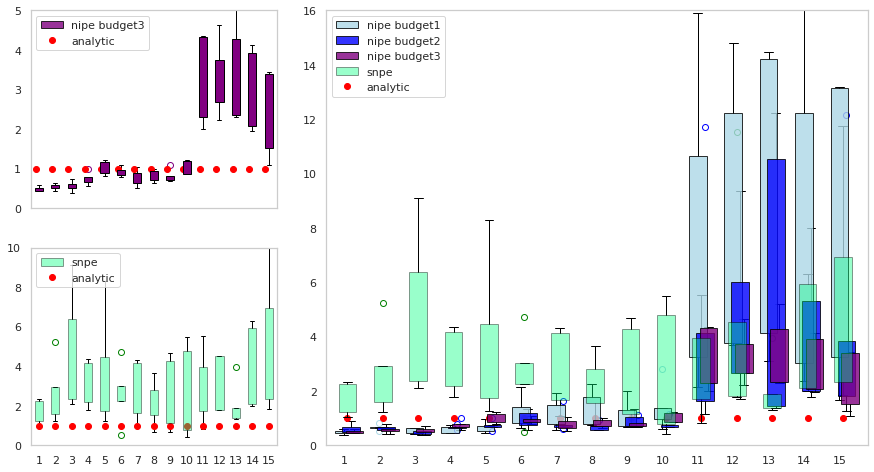

In [26]:
### plot variances:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_context('talk')
sns.set_context('notebook')

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

#nipe_box  = axes['A'].boxplot(nipe_noratio_array, patch_artist=True, boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'),            
#            flierprops=dict(color='lightblue', markeredgecolor='blue'),positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
#                                                                                 14, 15])
axes['A'].set(xticklabels=[])
#nipe_ratio_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
#            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 
#                                                                                 14.1, 15.1])

nipe_greater = axes['A'].boxplot(nipe_greater_ratio_array, patch_artist=True, boxprops=dict(facecolor='purple'), medianprops=dict(linewidth=0),            
            flierprops=dict(color='purple', markeredgecolor='purple'),positions=[1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 
                                                                                 14.2, 15.2])
axes['A'].set(xticklabels=[])


axes['A'].set_ylim(0,5)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='springgreen'), medianprops=dict(linewidth=0),flierprops=dict(color='green', markeredgecolor='green'),)
axes['B'].set_ylim(0,10)


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box = axes['C'].boxplot(nipe_noratio_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='lightblue'),  flierprops=dict(color='lightblue', markeredgecolor='lightblue'),
                  positions=[0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, 10.9, 11.9, 12.9, 13.9, 
                                                                                 14.9])


nipe_ratio_box = axes['C'].boxplot(nipe_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='blue'),            
            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1, 13.1, 
                                                                                 14.1, 15.1])

nipe_greater = axes['C'].boxplot(nipe_greater_ratio_array, medianprops = dict(linewidth=0),patch_artist=True, boxprops=dict(facecolor='purple'),            
            flierprops=dict(color='blue', markeredgecolor='blue'),positions=[1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 
                                                                                 14.2, 15.2])

for b in nipe_greater['boxes']:
    b.set_alpha(0.8)
    
for b in nipe_ratio_box['boxes']:
    b.set_alpha(0.8)

for b in nipe_box['boxes']:
    b.set_alpha(0.8)
    
for b in snpe_box['boxes']:
    b.set_alpha(0.4)
    
    
axes['C'].set(xticklabels=[])

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')

    
axes['B'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_c = axes['C'].boxplot(snpe_array, patch_artist=True, medianprops = dict(linewidth=0),
                  boxprops=dict(facecolor='springgreen'), flierprops=dict(color='springgreen', markeredgecolor='green'),
                  )

for b in snpe_c['boxes']:
    b.set_alpha(0.4)
    
axes['C'].set_ylim(0,16)

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_greater['boxes'][0], ana_plot[0]], ['nipe budget3',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], nipe_ratio_box['boxes'][0],  nipe_greater['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe budget1', 'nipe budget2', 'nipe budget3','snpe', 'analytic'], loc='upper left')

In [24]:
nipe_array = torch.stack(([mean_list[i] for i in range(10)]), dim=1)


snpe_array = torch.stack(([mean_list_snpe[i] for i in range(10)]), dim=1)

In [25]:
analytic.mean

tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])

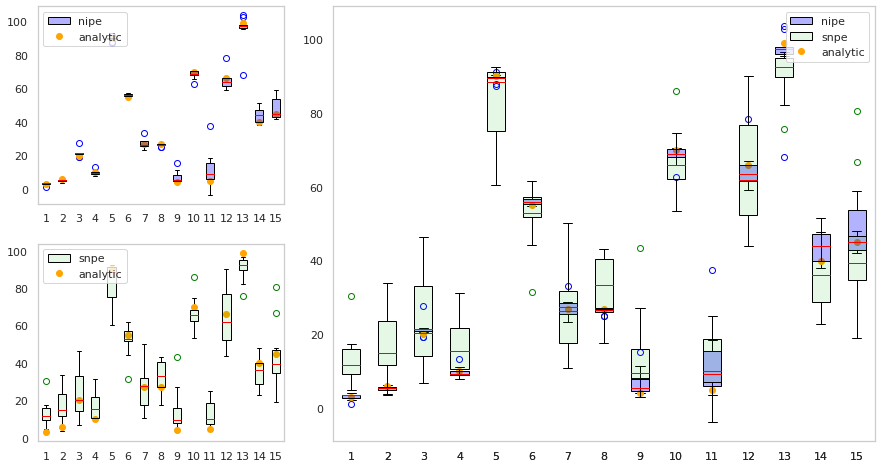

In [26]:
### plot means:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

nipe_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
            flierprops=dict(color='blue', markeredgecolor='blue'))

[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box['boxes']]

#axes['A'].set_ylim(0,15)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'),flierprops=dict(color='green', markeredgecolor='green'),)
#axes['B'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box['boxes']]


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box2 = axes['C'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'), flierprops=dict(color='blue', markeredgecolor='blue'),)

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['B'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_box2 = axes['C'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'), flierprops=dict(color='green', markeredgecolor='green'),)
#axes['C'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box2['boxes']]
[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box2['boxes']]

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe', 'snpe', 'analytic'], loc='upper right')